# Import Required Libraries
import cv2
import numpy as np
from picamera2 import Picamera2
import Motori
import Ostacolandia
import time
import matplotlib.pyplot as plt

In [21]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

In [22]:
def show_image_with_matplotlib(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # Nasconde gli assi
    plt.show()

# Define Constants and Configuration Parameters
HEIGHT, WIDTH, CHANNELS = 480, 640, 3
ALTEZZA_LINEA_INIZIALE = HEIGHT - 40
RAGGIO = 80
SEMI_RANGE = 214
DIM_SEMICERCHIO = SEMI_RANGE * 2 + 1
N_CERCHI = 4
VELOCITA = 35
KE = 0.125
KF = 3
VISUALIZZA = True
MAT_OMO = np.array([0.0015952, -0.0000101, -0.5088364, 0.0000158, -0.0018789, 0.8608532, -0.0000002, 0.0000089, 0.0033609])
KERNEL_DILATE = np.ones((12, 12), np.uint8)
punti = np.zeros((N_CERCHI + 1, 2), dtype=np.int16)
punti_real = np.zeros((N_CERCHI + 1, 2), dtype=np.float32)

In [23]:
# Define Constants and Configuration Parameters

# Dimensioni immagine: (altezza, larghezza, canali)
HEIGHT, WIDTH, CHANNELS = 480, 640, 3
ALTEZZA_LINEA_INIZIALE = HEIGHT - 40

# Parametri per la selezione del semicerchio
RAGGIO = 80
SEMI_RANGE = 214
DIM_SEMICERCHIO = SEMI_RANGE * 2 + 1
N_CERCHI = 4

# Parametri per il line following
VELOCITA = 35
KE = 0.125
KF = 3

# Flag per visualizzazione di debug
VISUALIZZA = True

# Matrice per trasformazione omografica
MAT_OMO = np.array([
    0.0015952, -0.0000101, -0.5088364,
    0.0000158, -0.0018789,  0.8608532,
   -0.0000002,  0.0000089,  0.0033609
])

# Kernel per dilatazione dell'immagine
KERNEL_DILATE = np.ones((12, 12), np.uint8)

# Array globali per memorizzare i punti rilevati
punti = np.zeros((N_CERCHI + 1, 2), dtype=np.int16)
punti_real = np.zeros((N_CERCHI + 1, 2), dtype=np.float32)

# Image Capture
img = cv2.imread('TestFoto/foto1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Captured Image')
plt.show()

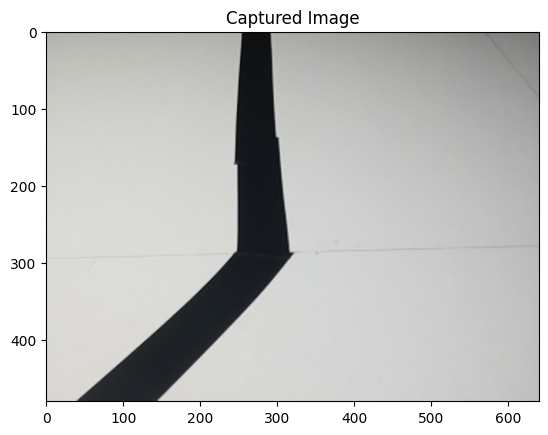

In [24]:
# Image Capture
img = cv2.imread('TestFoto/foto1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Captured Image')
plt.show()

# Line Processing
p_angolo = 0
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.dilate(img_gray, KERNEL_DILATE, iterations=1)
riga = img_gray[ALTEZZA_LINEA_INIZIALE, :]
grad = np.gradient(riga)
centro = int(round((np.argmax(grad) + np.argmin(grad)) / 2))
punti[0] = (ALTEZZA_LINEA_INIZIALE, centro)
if VISUALIZZA:
    cv2.circle(img, (centro, ALTEZZA_LINEA_INIZIALE), 5, (255, 0, 0), -1)
plt.plot(riga)
plt.title('Riga')
plt.show()
plt.plot(grad)
plt.title('Gradient of Riga')
plt.show()

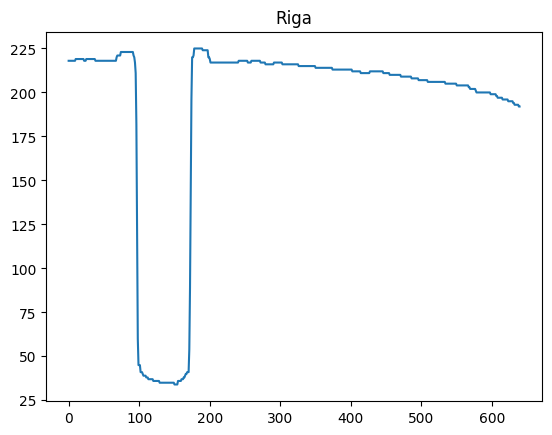

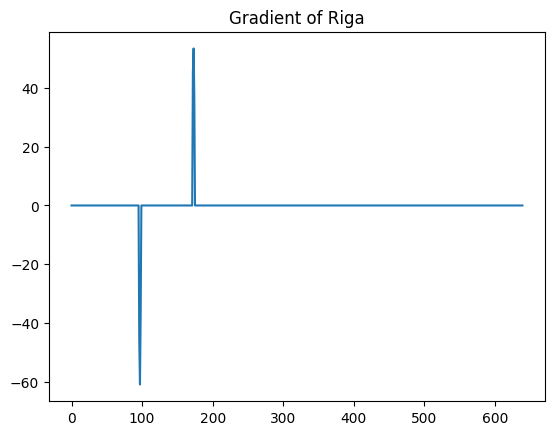

In [25]:
# Line Processing
p_angolo = 0
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.dilate(img_gray, KERNEL_DILATE, iterations=1)
riga = img_gray[ALTEZZA_LINEA_INIZIALE, :]
grad = np.gradient(riga)
centro = int(round((np.argmax(grad) + np.argmin(grad)) / 2))
punti[0] = (ALTEZZA_LINEA_INIZIALE, centro)
if VISUALIZZA:
    cv2.circle(img, (centro, ALTEZZA_LINEA_INIZIALE), 5, (255, 0, 0), -1)
plt.plot(riga)
plt.title('Riga')
plt.show()
plt.plot(grad)
plt.title('Gradient of Riga')
plt.show()

# Semicircle Processing
rad_step = np.pi / (DIM_SEMICERCHIO - 1)
for j in range(N_CERCHI):
    semicerchio = np.zeros(DIM_SEMICERCHIO, dtype=np.uint16)
    current_y, current_x = punti[j]
    max_radius = min(RAGGIO, current_y, (RAGGIO if j == 0 else HEIGHT - current_y), current_x, WIDTH - current_x) - 5
    angles = p_angolo + rad_step * np.arange(DIM_SEMICERCHIO)
    for i, angle in enumerate(angles):
        p_y = int(round(current_y - max_radius * np.sin(angle)))
        p_x = int(round(current_x + max_radius * np.cos(angle)))
        semicerchio[i] = img_gray[p_y, p_x]
        if VISUALIZZA:
            cv2.circle(img, (p_x, p_y), 1, (255, 0, 0), -1)
    semicerchio_grad = np.gradient(semicerchio)
    indice = int(round((np.argmax(semicerchio_grad) + np.argmin(semicerchio_grad)) / 2))
    p_angolo += rad_step * indice
    new_y = int(round(current_y - max_radius * np.sin(p_angolo)))
    new_x = int(round(current_x + max_radius * np.cos(p_angolo)))
    punti[j + 1] = (new_y, new_x)
    p_angolo -= np.pi / 2
    if VISUALIZZA:
        cv2.circle(img, (new_x, new_y), 5, (255, 0, 0), -1)
        cv2.circle(img, (current_x, current_y), max_radius, (0, 0, 255), 1)
if VISUALIZZA:
    cv2.line(img, (0, ALTEZZA_LINEA_INIZIALE), (WIDTH, ALTEZZA_LINEA_INIZIALE), (0, 255, 0), 3)
    cv2.line(img, (WIDTH // 2, 0), (WIDTH // 2, HEIGHT), (255, 0, 255), 3)
    cv2.line(img, (0, 20), (WIDTH, 20), (255, 0, 255), 3)
    cv2.circle(img, (punti[0][1] + SEMI_RANGE, punti[0][0]), 5, (0, 0, 255), -1)
    cv2.circle(img, (punti[0][1] - SEMI_RANGE, punti[0][0]), 5, (0, 0, 255), -1)
    cv2.imshow('Normale', img)

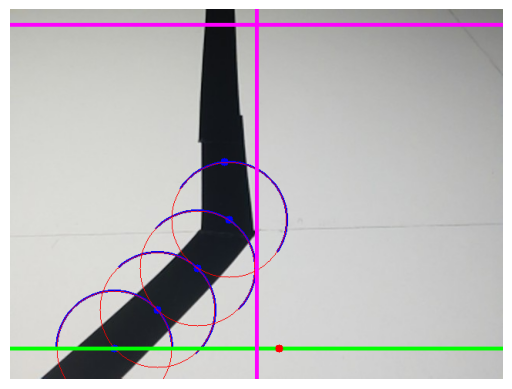

In [26]:
# Semicircle Processing
rad_step = np.pi / (DIM_SEMICERCHIO - 1)
for j in range(N_CERCHI):
    semicerchio = np.zeros(DIM_SEMICERCHIO, dtype=np.uint16)
    current_y, current_x = punti[j]
    max_radius = min(RAGGIO, current_y, (RAGGIO if j == 0 else HEIGHT - current_y), current_x, WIDTH - current_x) - 5
    angles = p_angolo + rad_step * np.arange(DIM_SEMICERCHIO)
    for i, angle in enumerate(angles):
        p_y = int(round(current_y - max_radius * np.sin(angle)))
        p_x = int(round(current_x + max_radius * np.cos(angle)))
        semicerchio[i] = img_gray[p_y, p_x]
        if VISUALIZZA:
            cv2.circle(img, (p_x, p_y), 1, (255, 0, 0), -1)
    semicerchio_grad = np.gradient(semicerchio)
    semicerchio_grad = np.where((-25 <= semicerchio_grad) & (semicerchio_grad <= 25), 0, semicerchio_grad)
    #va dritto se non trova niente
    if np.count_nonzero(semicerchio_grad):
        indice = int(round((np.argmax(semicerchio_grad) + np.argmin(semicerchio_grad)) / 2))
        p_angolo += rad_step * indice
        new_y = int(round(current_y - max_radius * np.sin(p_angolo)))
        new_x = int(round(current_x + max_radius * np.cos(p_angolo)))
        punti[j + 1] = (new_y, new_x)
        p_angolo -= np.pi / 2
    else:
        p_angolo = np.pi / 2

    if VISUALIZZA:
        cv2.circle(img, (new_x, new_y), 5, (255, 0, 0), -1)
        cv2.circle(img, (current_x, current_y), max_radius, (0, 0, 255), 1)
if VISUALIZZA:
    cv2.line(img, (0, ALTEZZA_LINEA_INIZIALE), (WIDTH, ALTEZZA_LINEA_INIZIALE), (0, 255, 0), 3)
    cv2.line(img, (WIDTH // 2, 0), (WIDTH // 2, HEIGHT), (255, 0, 255), 3)
    cv2.line(img, (0, 20), (WIDTH, 20), (255, 0, 255), 3)
    cv2.circle(img, (punti[0][1] + SEMI_RANGE, punti[0][0]), 5, (0, 0, 255), -1)
    cv2.circle(img, (punti[0][1] - SEMI_RANGE, punti[0][0]), 5, (0, 0, 255), -1)
    show_image_with_matplotlib(img)

# Homographic Transformation
punti_real = np.zeros((N_CERCHI + 1, 2), dtype=np.float32)
for i, (y, x) in enumerate(punti):
    denom = x * MAT_OMO[6] + y * MAT_OMO[7] + MAT_OMO[8]
controllo = angolo_linea + angolo_direzione

In [27]:
# Line Following
distanza_linea = punti_real[0][0]
angolo_linea = distanza_linea * KF
angolo_direzione = np.degrees(np.arctan2(punti_real[2][0] - punti_real[0][0], punti_real[2][1] - punti_real[0][1]))
controllo = angolo_linea + angolo_direzione